# ML for Classification Problem


In [1]:
# Libraries
 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"         

import numpy as np
import pandas as pd
from datetime import date, datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns#; sns.set()
sns.set(style="darkgrid")       
plt.figure(figsize=(16, 6))
%matplotlib inline  

#import inflection
import pickle

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# sklearn class

from collections import Counter

from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.experimental import enable_iterative_imputer             # still in experiment
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

## Data

- the Bank Marketing Dataset from Kaggle, to build a model to predict whether someone is going to make a deposit or not depending on some attributes, https://medium.com/analytics-vidhya/building-classification-model-with-python-9bdfc13faa4b
- Sometimes the first step is to construct the dependent variable, and this is the so-called "business understanding".
- Or need to drop unnecessary columns: e.g in the bank example, column "duration" is the last contact/phone call duration, in seconds (numeric). This attribute highly affects the output target, yet, the duration is not known before a call is performed. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. -- just like the competitor price in our case

In [3]:
# df = pd.read_excel('data/student_absence.xlsx')

df = pd.read_csv('https://raw.githubusercontent.com/rafiag/DTI2020/main/data/bank.csv')
df.drop(columns='duration', inplace=True)
df.shape
df.head()

(11162, 16)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,-1,0,unknown,yes


## EDA

Visualize our data in order to get a quick glimpse of what we have in our hands:
- check data is balanced or imbalanced for classification problem
- check the most important explaining factors
- boxplot, histogram, scatterplot

In [4]:
df['deposit'].value_counts(normalize=True)

# df['absence'].value_counts().plot(kind='bar')       # same color for 2 classes
# sns.countplot(df["absence"])            # future warning

# sns.countplot(x="deposit", data=df)

no     0.52616
yes    0.47384
Name: deposit, dtype: float64

In [5]:
# crosstab(): absence by track
pd.crosstab(df['deposit'], df['loan'])

loan,no,yes
deposit,,
no,4897,976
yes,4805,484


count    11162.000000
mean      1528.538524
std       3225.413326
min      -6847.000000
25%        122.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

<AxesSubplot:xlabel='balance'>

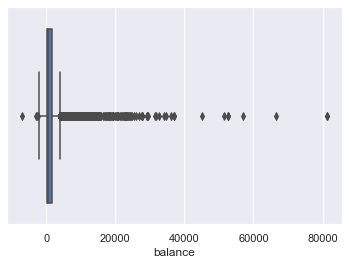

In [6]:
# balance has a highly-skewed distribution and negative values (thus cannot do log-transformation)

df.balance.describe()
sns.boxplot(x=df["balance"])

<font color=purple>Histogram, Measure of Shape: Skewness and Kurtosis</font>
- https://brownmath.com/stat/shape.htm
- histogram
- If the bulk of the data is at the left (the peak is toward the left) and the right tail is longer, we say that the distribution is **skewed right or positively skewed**;
- Skewness: thresholds [-1, -1/2, 0, 1/2, 1], if skewness is less than −1 or greater than +1, the distribution is highly skewed; moderately skewed, approximately symmetric; if skewness=0, perfectly symmetrical.
- Kurtosis: Higher values indicate a higher, sharper peak; lower values indicate a lower, less distinct peak. A normal distribution, which has a kurtosis of 3. 

[Text(0.5, 1.0, 'original data')]

[Text(0.5, 1.0, 'log-transformed data')]

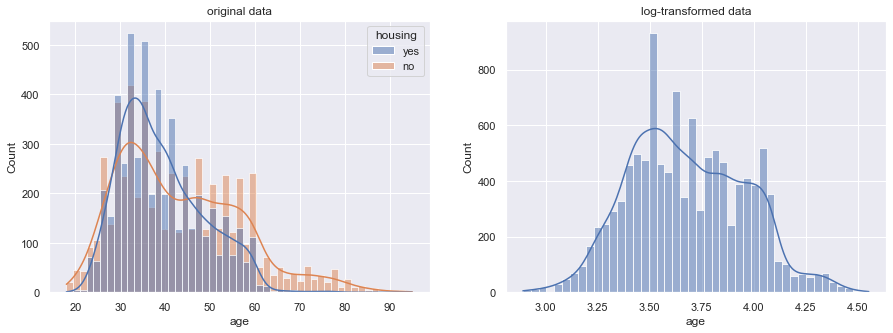

In [7]:
# distribution side-by-side, histogram

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df, x="age", kde=True, hue="housing", ax=axes[0]).set(title='original data')       

sns.histplot(np.log(df['age']), kde=True, ax=axes[1]).set(title='log-transformed data')
#sns.histplot(np.sqrt(df['undergrad_gpa']), kde=True, ax=axes[2]).set(title='sqrt-transformed data')
#Add a kernel density estimate to smooth the histogram

plt.show()


In [8]:
print(f'The skewness of the original data:', df['age'].skew())
print(f'The skewness of the log-transformed data:', np.log(df['age']).skew()) 

print('')

print(f'The kurtosis of the original data:', df['age'].kurtosis())
print(f'The kurtosis of the log-transformed data:', np.log(df['age']).kurtosis())

The skewness of the original data: 0.8627796373814871
The skewness of the log-transformed data: 0.20494778690287216

The kurtosis of the original data: 0.6215402926955051
The kurtosis of the log-transformed data: -0.4534472059697654


## Pre-Processing

SCIEM: **an Order of Operations for Data Preprocessing** - _Doing these in the right order will speed up the process by minimizing errors_

1. Split: train-test split -- <font color=blue>Do this first before any preprocessing </font>
2. Clean: miscellaneous cleaning, incl. removing duplicates and outliers
3. Impute: imputing missing values
4. Encode and Scale
    - Encode for categorical data
    - Scale, normalize, transform numeric data as needed (_When use MinMax Normalization, 0/1 dummy variables can also be included_)
    - Balance refers to correcting class imbalance
5. Feature Selection

### One-Hot-Encoding / Dummy Variables

- **Label Encoding** (Integer Encoding, Ordinal Encoding): convert categorical variable M/F into numerical 0/1 or 4 states into 0/1/2/3. But there is an **issue/limitation** of label encoding: - the integer values have a natural ordered relationship between each other, this may lead to the generation of priority issues in the training of data sets. A label with a high value may be considered to have high priority than a label having a lower value. 

- **One-Hot Encoding**: To deal with the above issue we will use One-Hot Encoding technique. This is where the integer encoded variable is removed and a new **binary variable** is added for each unique integer value. The binary variables are often called **"dummy variable"** in other fields such as statistics. 

    - The one-hot encoding creates one binary variable for each category. The problem is that this representation includes redundancy. This is the so-called **dummy variable trap**, which can be fixed by drop one. (_Dropping one binary variable essentially trying to avoid multicollinearity._) 


```
# with sklearn
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
# encoder = LabelEncoder()
encoder = OneHotEncoder(drop='first', sparse=False)
onehot = encoder.fit_transform(data)

# with pandas
data_encoded = pd.get_dummies(data, columns = ['State', 'Gender'])
```

<font color=purple>Why doing encoding first, before train_test_split?</font>

_In the example of 2U, there are less number of states in test data, and will generate different number of dummies variables and thus error in feature scaling when using X_train to train scaler and fit scaler with X_test. So we shall do encoding first, there will not "data leak"._

In [9]:
# for deposit kind of columns, have easier methods than LabelEncoder()

df['deposit'].unique()
df['deposit'] = np.where(df['deposit']=='yes', 1, 0)
df['deposit'].unique()

# df['deposite'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

array(['yes', 'no'], dtype=object)

array([1, 0])

In [10]:
# create dummy variables and drop one
# pd.get_dummies() will automatically drop the original categorical column

sorted(df["job"].unique().tolist())[0:5]

cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)           

df.shape

len([col for col in df.columns if 'job' in col])

# df.head(3)

['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management']

(11162, 42)

11

### Train-Test Split

The train-test split procedure is a fast and easy procedure to perform, the results of which allow you to compare the performance of machine learning algorithms for your predictive modeling problem. Use training data for "model learning" and test data for "model validation".

```
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, 
                                                    stratify=y, shuffle=True)
```

Things require your attention:
- <font color=blue>It's best practice to split the training and test data before manipulating the data in any way.</font> This prevents **data leakage**, which is when information from the test data is used to train the model. 

- Wisely use **'stratify' parameter**: especially useful when working around classification problems (particularly with imbalance classes), since if we don't provide this parameter we may end with a non-representative distribution of our target classes in our test group.

- **Shuffle** your data when needed: say our dataset is composed of 1000 students, of which the first 500 correspond to males, and the last 500 are females. If we did not add ```shuffle=True```, we will end up getting train data with 500 males and 300 females, and test data with 200 females.

- **Splitting by Indices**: It may so happen that you need to split 3 datasets into train and test sets, and of course, the splits should be similar. There is an elegant solution - to split by the indices of the dataset so that we can get the indices of the train and test set separately. 

```
all_indices=list(range(len(df)))
train_indices, test_indices = train_test_split(all_indices, test_size=0.2)
train = df.iloc[train_indices, :]
test = df.iloc[test_indices, :]
```

In [11]:
from sklearn.model_selection import train_test_split

y = df.deposit
X = df.drop('deposit', axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y, shuffle=True)

print("Train dataset:", X_train.shape, y_train.shape)
print("Test dataset:", X_test.shape, y_test.shape)

# percentage of each class
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

Train dataset: (8929, 41) (8929,)
Test dataset: (2233, 41) (2233,)


0    0.526151
1    0.473849
Name: deposit, dtype: float64

0    0.526198
1    0.473802
Name: deposit, dtype: float64

### Cleaning

This may include a variety of operations such as:
- drop columns that are not applicable
- remove duplicates
- remove rows based on filtered criteria
- remove outliers
- remove erroneous values
- change datatypes
- split up or combine data in string format
- bin (coverting a feature into groups, e.g. age_group)
- feature aggregation
- discretization

#### Duplicates

Pandas ```duplicated()``` and ```drop_duplicates()``` methods to find and remove duplicates

```
df.duplicated(subset=['student_id']).sum()
du.loc[df.duplicated(), :]
df.drop_duplicates(subset=None, keep='first')
```

In [13]:
# in our case, student_id should be unique, but check it anyway

X_train.duplicated().sum()

0

#### Outliers


**How to handle outliers?**

- Investigation: They can be legitimate observations and it’s important to investigate the nature of the outlier before deciding whether to drop it or not. <font color=blue>Be caution against removing outliers until you have identified the root cause of those outliers.</font>
- Remove: drop them if it is obvious that the outlier is due to incorrectly entered or measured data; based on Z-score or IQR score
- Transformation: can apply square root or log transformations, that will pull in high numbers
- Try a different model / ML algorithm which is not sensitive to outliers like Support Vector Machines (SVM). (_But SVM requires a large amount of time to process for larger dataset._)

**Interquartile Range (IQR) = Q3 - Q1**
- Boxplot: A plot to show the spread and centers of a data set; graphically display the five-number summary: min, Q1, median, Q3, max
    - _For the variability, remember that half your data for each group falls within the interquartile box. The longer the box and whiskers, the greater the variability of the distribution. The total length of the whiskers represents the range of the data._
    - _To determine whether a distribution is skewed, look at where the data fall compared to the median. For symmetric distributions, the length of the box and whiskers on both sides of the median should be approximately equal. If the two sides are not roughly equivalent, your distribution is skewed._
    
- Remove outliers based on IQR:

```
cols = [col1, col2]        # can be one or more columns
Q1 = X_train[cols].quantile(0.25)
Q3 = X_train[cols].quantile(0.75)
IQR = Q3 - Q1

mask = (X_train[cols] < (Q1 - 1.5 * IQR)) | (X_train[cols] > (Q3 + 1.5 * IQR))
X_train = X_train[~(mask).any(axis=1)]

# get the index for rows meet condition / been deleted
# idx = X_train.index[mask.any(axis=1)].tolist()

```


**Z-score**

> The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured. While calculating the Z-score we re-scale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be treated as the outliers. 

- Remove outliers based on z-score: in most of the cases a threshold of 3 or -3 is used

```
# Z-score, when all the columns are numerical

from scipy import stats

z = np.abs(stats.zscore(boston_df))
threshold = 3
boston_df_o = boston_df_o[(z < 3).all(axis=1)]              
boston_df_o.shape
```


```
X_train['balance'].describe()

# sns.boxplot(x=X_train['undergrad_gpa'])   

# breakdown by gender
sns.boxplot(x='deposit', y='balance', data=df)
```

In [14]:
# remove outliers for column age and undergrad_gpa

cols = ['age']           
# one or more columns, but 'balance' is really skewed, a lot of data will be removed if using IQR method

Q1 = X_train[cols].quantile(0.25)
print("Q1:", Q1)                          # return a number for each column
Q3 = X_train[cols].quantile(0.75)
IQR = Q3 - Q1

mask = (X_train[cols] < (Q1 - 1.5 * IQR)) | (X_train[cols] > (Q3 + 1.5 * IQR))
mask.head(3)

# get the index for rows meet condition / been deleted
idx = X_train.index[mask.any(axis=1)].tolist()
print(idx[0:10])

X_train.shape
X_train = X_train[~(mask).any(axis=1)]
X_train.shape                             

# but y_train still have "full" data points -- drop rows based on index
y_train.shape
y_train = y_train.drop(idx)
y_train.shape

Q1: age    32.0
Name: 0.25, dtype: float64


,age
2536,False
8283,False
10439,False


[2809, 6227, 3530, 7941, 2709, 3194, 3486, 1373, 3546, 6478]


(8929, 41)

(8799, 41)

(8929,)

(8799,)

### Missing Values

<font color=blue>The sklearn implementation of ML algorithms don't support the presence of the missing values. And imputing missing value has to be done before encoding because the encoders do not like NaN's.</font>

**7 Ways to Handle Missing Values in ML**

- Investigation: Missing could be Not at Random, e.g. data missing indicate they are not an engaged customer; In this case removing observations with missing values can produce a bias in the model.

- Delete rows or columns with (a lot) missing values. However, this will cause problems if 1) data size is small, or 2) they are not randomly missing.

- Impute missing values for continuous variable: mean, median or mode of the remaining values in the column; _but his method can cause data leakage and do not factor the covariance between features._

- Impute NaN for categorical variable: the most frequent category; if the number of NaN is very large then it can be replaced with a new category like 'others' (_but addition of new features to the model while encoding, which may result in poor performance_).

- Other imputation methods: methods depending on the nature of the data or data type, e.g. for the data variable having longitudinal behavior, it might make sense to use the last valid observation to fill the missing value. Or for the time-series dataset variable, it makes sense to use the interpolation of the variable before and after a timestamp for a missing value. 

```
df["age"] = df["age"].fillna(method='ffill', limit=1)
df["age"] = df["age"].interpolate(method='linear', limit_direction='forward', axis=0)
```

- Using algorithms that support missing values: All the ML algorithms don't support missing values but some ML algorithms are robust to missing values in the dataset (K-NN, Naive Bayes, RandomForest).

- Predictition of missing values: the regression or classification model can be used for the prediction of missing values depending on the nature (categorical or continuous) of the feature having NaN, using other features which don't having NaN. For example, predict income with education, occupation, gender and age.


**Sklearn** 
- SimpleImputer class
- Going beyond, KNN Imputer and Iterative Imputer class

```
# with Scikit Imputer
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputer = imputer.fit(X[:, 1:3])
X[:, 1:3] = imputer.transform(X[:, 1:3])

# fancy KNN Imputer
imputer = KNNImputer(n_neighbors=2)
imputer.fit_transform(X)
```

```
# missing values
X_train[['gender', 'state']] = X_train[['gender', 'state']].fillna('Other')

# undergrad_gpa
median_gpa = X_train['undergrad_gpa'].median()
X_train['undergrad_gpa'] = X_train['undergrad_gpa'].fillna(median_gpa)      

# test dataset - impute with value from train dataset
X_test[['gender', 'state']] = X_test[['gender', 'state']].fillna('Other')
X_test['undergrad_gpa'] = X_test['undergrad_gpa'].fillna(median_gpa) 
```

### Feature Transformation
To give the right shape to our dataset – **Gaussian like / normal distribution**, use skewness and kurtosis
> In many statistical techniques, we assume that the errors are normally distributed. This assumption allows us to construct confidence intervals and conduct hypothesis tests. By transforming your target variable, we can (hopefully) normalize our errors (if they are not already normal). Additionally, transforming our variables can improve the predictive power of our models because transformations can cut away white noise.

- **Log transformation** or Square root transformation: Sometimes log transformation cannot help make data more normal, so try different methods and compare the results
- **Power transformation, BoxCox**: difficult to interpret; the Box-Cox transformation usually gives the median of the forecast distribution when we revert the transformed data to its original scale.
- Binning, binarizing and arbitrary transformations


### Feature Scaling

**Feature Scaling** is a technique of bringing down the values of all the independent features of our dataset on the same scale. 
If we didn't do feature scaling then the machine learning model gives higher weightage to higher values and lower weightage to lower values. Also, takes a lot of time for training the machine learning model.

**Why should we use feature scaling?**
- ML algorithms like linear regression, logistic regression, neural network, etc, that use gradient descent as an optimization technique require data to be scaled. Take a look at the formula for gradient descent, the presence of feature value X in the formula will affect the step size of the gradient descent; Having features on a similar scale can halpe the gradient descent converge more quickly towards the minima.

- Distance-based algorithms like KNN, K-means, and SVM are most affected by the range of features. This is because behind the scenes they are using distances between data points to determine their similarity. For example, a data containing GPA and salary, since both the features have different scales, there is a chance that higher weightage is given to features with higher magnitude (ie. algorithm to be biassed towards one feature). -- the Euclidean distance will be more comparable after we applied scaling.

- Tree-based algorithms, on the other hand, are fairly insensitive to the scale of the features.


**Feature scaling techniques** 
- **Normalization**: also known as min-max scaling or **min-max normalization**, it is the simplest method and consists of rescaling the range of features to scale **the range [0, 1]**.  (_Normalization is a scaling technique in which values are shifted and rescaled so that they end up ranging between 0 and 1._)
$$x' = \frac{x - min(x)}{max(x) - min(x)}$$

- **Standardization**: makes the values of each feature in the data have zero mean and unit variance. The general method of calculation is to determine the distribution mean and standard deviation for each feature and calculate the new data point by the following formula: (_Standardization is another scaling technique where the values are centered around the mean with a unit standard deviation. Note that in this case, the values are not restricted to a particular range._)
$$x' = \frac{x- \bar{x}}{\sigma}$$

- **Scaling to unit length**: The aim of this method is to scale the components of a feature vector such that the complete vector has length one. This usually means dividing each component by the Euclidean length of the vector:
$$x' = \frac{x}{||x||}$$, where $||x||$ is the Euclidean length of the feature vector

- **Robust Scalar**: is one of the best scaling techniques when we have **outliers** present in our dataset.
$$x' = \frac{x - x_m}{IQR}$$
where $X_m$ means 'median of X', the interquartile range IQR = 75 Quartile - 25 Quartile

- **Gaussian Transformation**: when our dataset doesn't follow Gaussian / Normal distribution (Bell Curve) then we use Gaussian transformation. Types of Gaussian Transformation include Log Transformation, Reciprocal Transformation, Square Root Transformation, Exponential Transformation, Box-Cox Transformation.

**The million-dollar question: normalization or standardization?** 

While there is no obvious answer to this question, it really depends on the application, there are still a few generalizations that can be drawn.

- Normalization is good to use when the distribution of data does not follow a Gaussian distribution. It can be useful in algorithms that do not assume any distribution of the data like K-Nearest Neighbors.

- In Neural Networks algorithm that require data on a 0–1 scale, normalization is an essential pre-processing step. Another popular example of data normalization is image processing, where pixel intensities have to be normalized to fit within a certain range (i.e., 0 to 255 for the RGB color range).

- Standardization can be helpful in cases where the data follows a Gaussian distribution. Though this does not have to be necessarily true. Since standardization does not have a bounding range, so, even if there are outliers in the data, they will not be affected by standardization.

- In clustering analyses, standardization comes in handy to compare similarities between features based on certain distance measures. Another prominent example is the **Principal Component Analysis (PCA)**, where we usually prefer standardization over Min-Max scaling since we are interested in the components that maximize the variance.

There are some points which can be considered while deciding whether we need Standardization or Normalization

- Standardization may be used when data represent **Gaussian Distribution**, while Normalization is great with Non-Gaussian Distribution
- Impact of **Outliers** is very high in Normalization

**To conclude, you can always start by fitting your model to raw, normalized, and standardized data and compare the performance for the best results.**


_**It is a good practice to:**_
- fit the scaler on the training data and then use it to transform the testing data. This would avoid any data leakage during the model testing process. 
- Also, the scaling of target values is generally not required. 
- Lastly, apply standardization only on numerical features, but normalization on both numerical and one-hot encoded features. _-- but I remember it is said StandardScaler is chosen over MinMaxScalar by some reason_


```
# use MinMaxScaler for simplicity here 

from sklearn.preprocessing import MinMaxScaler

norm = MinMaxScaler().fit(X_train)
X_train_smote_norm = norm.transform(X_train_smote)
X_test_norm = norm.transform(X_test)
```

In [15]:
from sklearn.preprocessing import StandardScaler

# Feature scaling should not incl. dummy variables
# num_df = df.select_dtypes(exclude='object')           # do this before creating dummy variables
# X_train.select_dtypes(include='float64').columns.tolist()        # since dummy variables is "uint8"

num_cols = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous'] 

std_scaler = StandardScaler().fit(X_train[num_cols])
X_train[num_cols] = std_scaler.transform(X_train[num_cols])

X_test[num_cols] = std_scaler.transform(X_test[num_cols])

C:\Users\yshen\Anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### Imbalanced Data

Standard ML techniques such as Decision Tree and Logistic Regression **have a bias towards the majority class, and they tend to ignore the minority class**, if we have imbalanced data distribution in our dataset.

<font color=blue>should do most pre-processing steps (encoding, normalization/standardization, etc) before under/over-sampling the data.</font>
> This is because many sampling techniques require a simple model to be trained (e.g. SMOTE uses a k-NN algorithm to generate samples, ClusteringCentroids under-sampling technique involves k-means clustering). These models have better performance on pre-processed datasets (e.g. both k-NN and k-means use euclidean distance, which requires the data to be normalized).

**8 Tactics to Combat Imbalanced Classes** in Your Machine Learning Dataset

- Collect more data
- Change performance metric: instead of the traditional classification **Accuracy**, consider:
     - Confusion Matrix: A table showing correct predictions and types of incorrect predictions
     - Precision: the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives (Type I error).
     $$P = \frac{TP}{TP + FP}$$
     - Recall: the number of true positives divided by the number of positive values in the test data. The recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives (Type II error).
     $$R = \frac{TP}{TP + FN}$$
     - F1 Score: a weighted average of precision and recall
     $$F1 = \frac{2(P * R)}{P + R}$$
     - ROC Curve (receiver operating characteristic curve) and ACU (Area under ROC Curve): An ROC curve plots True Positive Rate vs. False Positive Rate at different classification thresholds (e.g. the threshold commonly used is 0.5). Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. AUC represents the likelihood of your model distinguishing observations from two classes. 
     
- Resample your dataset

    - over-sampling (sampling with replacement):
    - under-sampling
    - consider testing random and non-random (e.g. stratified) sampling schemes
    - consider testing different resampled ratios (e.g. target other ratios instead of 1:1 ratio in a binary classification problem)
    
    
- Try generate synthetic samples: There are systematic algorithms that you can use to generate synthetic samples. The most popular of such algorithms is called **SMOTE** or the **Synthetic Minority Over-sampling Technique**. 

- Try different algorithms: should at least spot-checking a variety of different types of algorithms on a given problem; for example, decision trees often perform well on imbalanced datasets (_The splitting rules that look at the class variable used in the creation of the trees, can force both classes to be addressed_).

- Try panelized models (cost-sensitive training): Penalized classification imposes an additional cost on the model for making classification mistakes on the minority class during training. There are penalized versions of algorithms such as penalized-SVM and penalized-LDA. Using penalization is desirable if you are locked into a specific algorithm and are unable to resample or you’re getting poor results. ```svc_model = SVC(class_weight='balanced', probability=True)```


#### **SMOTE**

SMOTE is an intelligent alternative to oversampling: rather than creating duplicates of the minority class, it creates synthetic data points that are relatively similar to the original ones. 

Under the hood, the SMOTE algorithm works in 4 simple steps:
1. Choose a minority class input vector
2. Find its k nearest neighbors (k_neighbors is specified as an argument in the SMOTE() function)
3. Choose one of these neighbors and place a synthetic point anywhere on the line joining the point under consideration and its chosen neighbor
4. Repeat the steps until data is balanced

Use SMOTE, your model will start detecting more cases of the minority class, which will result in **an increased recall, but a decrease precision**. The decision of a whether this is wanted behavior will always be depending on your business case.

<font color=blue>Only do resampling on train data</font>
> Essentially applying SMOTE makes the job easier for the model: SMOTE generates artificial instances which tend to have the same properties as each other, so it's easier for the model to capture their patterns. However these instances are rarely a good representative sample for the minority class, so there's a higher risk that the model overfits. Of course if SMOTE is also applied to the test set, the model appears to perform better. This is the equivalent of changing a difficult question to an easier one in order to answer the question better.

In [16]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_train_smote))

Original dataset shape Counter({0: 4672, 1: 4127})
Resample dataset shape Counter({1: 4672, 0: 4672})


### Feature Selection
<font color=blue>Feature selection that involves narrowing down features manually based on domain knowledge should happen before all of these steps as part of data understanding. Feature selection using algorithms should happen after preprocessing. </font>

**Why Feature Selection?**
- Curse of dimensionality - overfitting
- Occam's razor: we want our models to be simple and explainable
- Garbage in garbage out: when we have many non-informative features
- A large number of features make a model bulky, time-taking, and harder to implement in production

Let me summarize the importance of feature selection for you:
- It enables the machine learning algorithm to train faster.
- It reduces the complexity of a model and makes it easier to interpret.
- It improves the accuracy of a model if the right subset is chosen.
- It reduces Overfitting.

**So What do we do?**

We select only useful features. Most feature selection methods can be divided into 3 major buckets:
- **Filter Method**: specify some metric and based on that filter features
    - Pearson Correlation: check the absolute value of the Pearson's correlation between the target and numerical features in our dataset. We keep the top n features based on this criterion.
    - Chi-Squared: calculate the chi-square metric btw the target and the numerical variable and only select the variable with the maximum chi-squared values. 
    - ```chi_selector = SelectKBest(chi2, k='all')```
    
- **Wrapper Method**: wrapper methods consider the selection of a set of features as a search problem.
    - Backward Elimination, Forward Selection, Bidirectional Elimination
    - Recursive Feature Elimination (RFE): from sklearn documentation:
    > Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

- **Embedded Method**: embedded methods use algorithms that have built-in feature selection methods.
    - Lasso: Lasso regression uses L1 norm as regularizer, and unlike Ridge regression, Lasso Regularizer forces a lot of feature weights to be zero. -- _still use LogisticRegression but with penalty argument, ```LogisticRegression(penalty="l1")```_
    - Tree-based: use RandomForest to select features based on feature importance. We calcuate feature importance using node impurities in each decision tree. In Random forest, the final feature importance is the average of all decision tree feature importance. (_Similar code, only change the selector part to ```embeded_rf_selector=SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)```_) We could also have used a LightGBM, or an XBBoost object as long it has a ```feature_importances_```attributes.


**Conclusion: - which method to choose?**

Following points will help you make this decision:
- Filter method is less accurate. It is great while doing EDA, it can also be used for checking multi co-linearity in data.
- Wrapper and Embedded methods give more accurate results but as they are computationally expensive, these method are suited when you have lesser features (~20).


**Difference between dimensionality reduction and feature selection**

> Sometimes, feature selection is mistaken with dimensionality reduction. But they are different. Feature selection is different from dimensionality reduction. Both methods tend to reduce the number of attributes in the dataset, but a dimensionality reduction method does so by creating new combinations of attributes (sometimes known as feature transformation), whereas feature selection methods include and exclude attributes present in the data without changing them. 
Some examples of dimensionality reduction methods are Principal Component Analysis, Singular Value Decomposition, Linear Discriminant Analysis, etc.


**Feature Selection for Categorical Variables**

The two most commonly used feature selection methods for categorical input data when the target variable is also categorical (e.g. classification predictive modeling) are the **chi-squared statistic** and the **mutual information statistic**.


```
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# k features with highest chi-squared statistics are selected
chi_selector = SelectKBest(chi2, k=8)             # k=num_feats
chi_selector.fit(X_train_std_smote, y_train_smote)

chi_support = chi_selector.get_support()           # True or False
chi_support

print(chi_selector.get_support().sum(), 'selected features')

selected_feature = X_train.columns[(chi_selector.get_support())]
selected_feature

# 1) I don't know which value for k
# 2) the result is quite different from SelectFromModel(RandomForest)
```

In [17]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

embeded_selector = SelectFromModel(LogisticRegression(C=1, penalty="l1", solver='liblinear'))  
# , max_features=num_feats
# ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

#embeded_selector = SelectFromModel(RandomForestClassifier(n_estimators = 100))

embeded_selector.fit(X_train_smote, y_train_smote)

embeded_support = embeded_selector.get_support()
print('N of features selected:', embeded_selector.get_support().sum())

embeded_feature = X_train.columns[(embeded_selector.get_support())]
embeded_feature

# AttributeError: 'numpy.ndarray' object has no attribute 'columns'
# X_train_smote_norm is np.ndarray, but X_train is still pd.DataFrame, type(X_train_smote_norm)
# --> when I only do feature scaling on num_cols, there is no such problem

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

N of features selected: 39


Index(['age', 'balance', 'day', 'campaign', 'pdays', 'previous',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'housing_yes', 'loan_yes', 'contact_telephone',
       'contact_unknown', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

#### RFE 

**Recursive Feature Elimination**

Refer to here, https://machinelearningmastery.com/rfe-feature-selection-in-python/

Practical tips:
- As we would have guessed, we could use any estimator with the RFE method. In this case, we use ```LogisticRegression```, and the RFE observes the ```coef_``` attribute of the ```LogisticRegression``` object.
- ```n_features_to_select``` is arbitrary value --> need to find the optimum number of features, for which the accuracy is the highest

```
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=20, step=10, verbose=5)
rfe_selector.fit(X_train_smote, y_train_smote)

rfe_selector.support_
rfe_selector.ranking_

rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:, rfe_support].columns.tolist()

print(str(len(rfe_feature)), 'selected features')
embeded_rf_feature = X_train.columns[(rfe_selector.get_support())] 
embeded_rf_feature
# the result is completely different from embeded_rf_selector above
```

<font color=purple>RFE always give non-sense result, why? </font>
    
_Like here in the bank example, all the important variables are elimiated, the variables left are all dummy variables._

### Multicollinearty

Detecting multicollinearity using **VIF - Variance Inflation Factor**

> VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable. Or, _VIF score of an independent variable represents how well the variable is explained by other independent variables._

$$VIF = \frac{1}{1-R^2}$$
How to read the result?
- VIF starts at 1 and has no upper limit
- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

**Why is multicollinearity not checked in modern ML?**

> The reason is because the goals of "traditional statistics" are different from many Machine Learning techniques. Multicollinearity screw with coefficient estimates, but doesn't change the predictive power of the model. Traditional statistical models care about interpretability, but modern ML cares more about prediction.

```
cor = df.corr()
sns.heatmap(cor, annot=True)
```

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

def calc_vif(X):
    vif_table = pd.DataFrame()
    vif_table["Variable"] = X.columns
    vif_table["VIF_Score"] = [vif(X.values, i) for i in range(X.shape[1])]
    return vif_table

result = calc_vif(X_train)
result.head(8)
# why age and undergrad_gpa has such high values?

,Variable,VIF_Score
0,age,1.841255
1,balance,1.041158
2,day,1.260581
3,campaign,1.101701
4,pdays,2.866533
5,previous,1.647491
6,job_blue-collar,2.368597
7,job_entrepreneur,1.278619


## Modeling

### Model Comparison

https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

<font color=blue>The key to a fair comparison of machine learning algorithms is ensuring that each algorithm is evaluated in the same way on the same data.</font>

Listed 4 commonly-used models for a binary classification problem, their advantages and disadvantages, and a helper function to evaluate each trained model with commonly used metrics.
- Decision Tree
- Random Foreast
- Gaussian Naive Bayes
- K-Nearest Neighbours

Other common algorithms
- Logistic Regression
- Support Vector Machines
- Linear Discriminant Analysis
- Classification and Regression Trees (CART)

In [19]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics
    
    # predict
    y_pred = model.predict(x_test)
    
    # calculate accuracy, precision, reccall, and f1-score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    
    # calcualte Area Under Curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    
    # display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1,  
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

In [20]:
from sklearn import tree

# Building Decision Tree model 
dtc = tree.DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

# Evaluate Model
dtc_eval = evaluate_model(dtc, X_test, y_test)

# Print result
print('Accuracy:', dtc_eval['acc'])
print('Precision:', dtc_eval['prec'])
print('Recall:', dtc_eval['rec'])
print('F1 Score:', dtc_eval['f1'])
#print('Cohens Kappa Score:', dtc_eval['kappa'])
print('Area Under Curve:', dtc_eval['auc'])
print('Confusion Matrix:\n', dtc_eval['cm'])

DecisionTreeClassifier(random_state=0)

Accuracy: 0.6300940438871473
Precision: 0.6124031007751938
Recall: 0.5973534971644613
F1 Score: 0.6047846889952152
Area Under Curve: 0.6284639826247838
Confusion Matrix:
 [[775 400]
 [426 632]]


In [21]:
# random forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

rf_eval = evaluate_model(rf, X_test, y_test)

RandomForestClassifier(random_state=0)

In [22]:
# Naive Bayes

from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

nb_eval = evaluate_model(nb, X_test, y_test)

GaussianNB()

In [23]:
# K-Nearest Neighbors

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

knn_eval = evaluate_model (knn, X_test, y_test)

KNeighborsClassifier()

In [24]:
# I also add logistic regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

lr_eval = evaluate_model(lr, X_test, y_test)

LogisticRegression()

Text(0.5, 0.98, 'Model Comparison')

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

Text(0.5, 0, 'Metrics')

[Text(0.22499999999999998, 0, 'Accuracy'),
 Text(1.225, 0, 'Precision'),
 Text(2.225, 0, 'Recall'),
 Text(3.225, 0, 'F1')]

Text(0, 0.5, 'Score')

(0.0, 1.0)

Text(0.5, 1.0, 'Evaluation Metrics')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve')

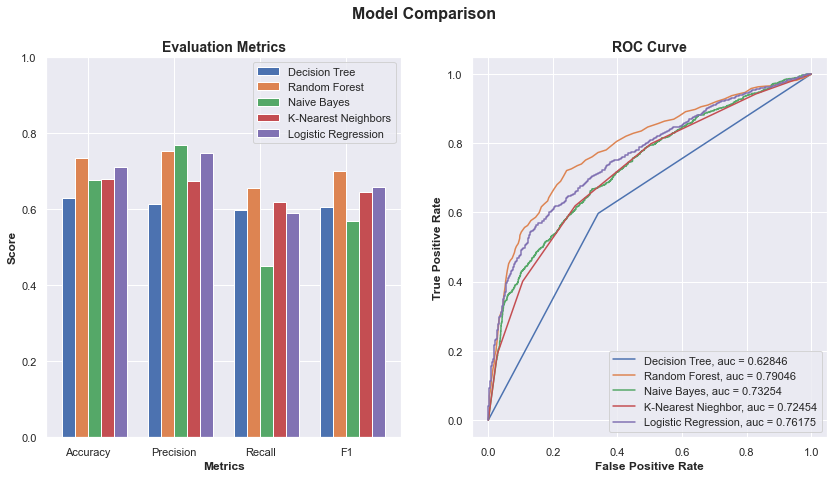

In [25]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.15
dtc_score = [dtc_eval['acc'], dtc_eval['prec'], dtc_eval['rec'], dtc_eval['f1']]
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1']]
nb_score = [nb_eval['acc'], nb_eval['prec'], nb_eval['rec'], nb_eval['f1']]
knn_score = [knn_eval['acc'], knn_eval['prec'], knn_eval['rec'], knn_eval['f1']]
lr_score = [lr_eval['acc'], lr_eval['prec'], lr_eval['rec'], lr_eval['f1']]

## Set position of bar on X axis
r1 = np.arange(len(dtc_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

## Make the plot
ax1.bar(r1, dtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r2, rf_score, width=barWidth, edgecolor='white', label='Random Forest')
ax1.bar(r3, nb_score, width=barWidth, edgecolor='white', label='Naive Bayes')
ax1.bar(r4, knn_score, width=barWidth, edgecolor='white', label='K-Nearest Neighbors')
ax1.bar(r5, lr_score, width=barWidth, edgecolor='white', label='Logistic Regression')

## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(dtc_eval['fpr'], dtc_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(dtc_eval['auc']))
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(nb_eval['fpr'], nb_eval['tpr'], label='Naive Bayes, auc = {:0.5f}'.format(nb_eval['auc']))
ax2.plot(knn_eval['fpr'], knn_eval['tpr'], label='K-Nearest Nieghbor, auc = {:0.5f}'.format(knn_eval['auc']))
ax2.plot(lr_eval['fpr'], lr_eval['tpr'], label='Logistic Regression, auc = {:0.5f}'.format(lr_eval['auc']))

## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()

From the figures above we can see that our Random Forest model tops the other models in 5 of the 6 metrics we evaluate, except precision. So we can assume that Random Forest is the right choice to solve our problem.  --> <font color=purple> I add Logistic Regression, and found it is just slightly worse than Random Foreast</font>

### Model Optimisation

to optimise our RandomForest model by tuning the hyper parameters available from the scikit-learn library

**Tuning Hyperparameter with GridSearchCV**

We will use GridSearchCV functionality from sklearn to find the optimal parameter for our model. We will provide our baseline model (named rf_grids), scoring method (in our case we will use recall as explained before), and also various parameters value we want to try with our model. The GridSearchCV function will then **iterate through each parameters combination to find the best scoring parameters**.

This function also allow us to use **cross validation** to train our model, where on each iteration our data will be divided into 5 (the number are adjustable from the parameter) fold. The models then will be trained on 4/5 fold of the data leaving the final fold as validation data, this process will be repeated for 5 times until all of our folds are used as validation data.

To see the result of which parameters combination works best we can access the **```best_params_``` attribute** from our grid search object.

_Note: The more combination provided, the longer the process will take. -- really takes a while; Alternatively, you can also try ```RandomizedSearchCV``` to only randomly select specified number of parameters which can result in faster running time._


<font color=purple>GridSearchCV take a quite long time </font>

```
from sklearn.model_selection import GridSearchCV

# create the parameter grid based on the results of ranom search
param_grid = {
    'max_depth': [50, 80, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500, 750, 1000]
}

# create a base model
rf_grids = RandomForestClassifier(random_state=0)

# Initiate the grid search model
grid_search = GridSearchCV(estimator=rf_grids, param_grid=param_grid, scoring='recall',
                          cv=5, n_jobs=-1, verbose=2)

# fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_
```

### Evaluating Optimised Model

After finding the best parameter for the model we can access the best_estimator_ attribute of the GridSearchCV object to save our optimised model into variable called best_grid. We will calculate the 6 evaluation metrics using our helper function to compare it with our base model on the next step.

```
# select best model with best fit

best_grid = grid_search.best_estimator_

# evaluate model
best_grid_eval = evaluate_model(best_grid, X_test, y_test)

# Print result
print('Accuracy:', best_grid_eval['acc'])
print('Precision:', best_grid_eval['prec'])
print('Recall:', best_grid_eval['rec'])
print('F1 Score:', best_grid_eval['f1'])
print('Area Under Curve:', best_grid_eval['auc'])
print('Confusion Matrix:\n', best_grid_eval['cm'])
```

## Save Output

We have our model, what next? As data scientist it’s important to be able to develop a model with good re-usability. 

- Making predictions and save it into a csv file
- Saving model: using joblib so you can use it in production or just save it for later use without having to repeat the whole process. This model can then be loaded on another machine to make new prediction without doing the whole training process again.

```
# save prediction to csv file

df['deposit_pred'] = rf.predict(feature)
df['deposit_pred'] = df['deposit_pred'].apply(lambda x: 'yes' if x==0 else 'no')

df.to_csv('deposit_prediction.csv', index=False)
```

```
from joblib import dump, load

# saving model
dump(rf, 'bank_deposit_classification.joblib')

# loading model
clf = load('bank_deposit_classification.joblib')
```

## Logistic Regression

Logistic Regression is a good starting point

In [36]:
df = pd.read_csv('https://raw.githubusercontent.com/rafiag/DTI2020/main/data/bank.csv')
df.drop(columns='duration', inplace=True)

In [37]:
# dummy variables
df['deposit'] = np.where(df['deposit']=='yes', 1, 0)

cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)   

In [38]:
# train-test-split

y = df.deposit
X = df.drop('deposit', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y, shuffle=True)

print("Train dataset:", X_train.shape, y_train.shape)
print("Test dataset:", X_test.shape, y_test.shape)


Train dataset: (8929, 41) (8929,)
Test dataset: (2233, 41) (2233,)


In [39]:
# feature scaling: standardization numerical variable

num_cols = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous'] 

std_scaler = StandardScaler().fit(X_train[num_cols])
X_train[num_cols] = std_scaler.transform(X_train[num_cols])

X_test[num_cols] = std_scaler.transform(X_test[num_cols])

C:\Users\yshen\Anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\yshen\Anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [40]:
# fix imbalanced class issue

smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [41]:
# feature selection with embeded method

embeded_selector = SelectFromModel(LogisticRegression(C=1, penalty="l1", solver='liblinear'))  

embeded_selector.fit(X_train_smote, y_train_smote)

embeded_support = embeded_selector.get_support()
print('N of features selected:', embeded_selector.get_support().sum())

embeded_feature = X_train.columns[(embeded_selector.get_support())]
embeded_feature

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

N of features selected: 37


Index(['age', 'balance', 'day', 'campaign', 'pdays', 'previous',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unknown', 'marital_married',
       'marital_single', 'education_secondary', 'education_tertiary',
       'housing_yes', 'loan_yes', 'contact_telephone', 'contact_unknown',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_other', 'poutcome_success'],
      dtype='object')

In [42]:
# selected features only

features_selected = embeded_feature.tolist()

X_train = X_train[features_selected]
X_test = X_test[features_selected]

In [43]:
# statsmodels

import statsmodels.api as sm

X_train_cons = sm.add_constant(X_train)
reg_log = sm.Logit(y_train, X_train_cons)
results_log = reg_log.fit()

# results_log.summary()

Optimization terminated successfully.
         Current function value: 0.570200
         Iterations 6


C:\Users\yshen\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<font color=purple> _Variables normalized, then how to interpret the coefficients?_ </font>

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model = LogisticRegression()
result = model.fit(X_train, y_train)

pred = model.predict(X_test)

In [45]:
acc = metrics.accuracy_score(y_test, pred)
prec = metrics.precision_score(y_test, pred)
rec = metrics.recall_score(y_test, pred)
f1 = metrics.f1_score(y_test, pred)

print("accuracy:", acc)
print("precision:", prec)
print("recall:", rec)
print("F1 score:", f1)

accuracy: 0.7115987460815048
precision: 0.7458432304038005
recall: 0.5935727788279773
F1 score: 0.6610526315789473


[[961 214]
 [430 628]]


Text(0.5, 1.0, 'Seaborn Confusion Matrix with labels\n\n')

Text(0.5, 12.5, '\nPredicted Values')

Text(30.5, 0.5, 'Actual Values ')

[Text(0.5, 0, 'False'), Text(1.5, 0, 'True')]

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

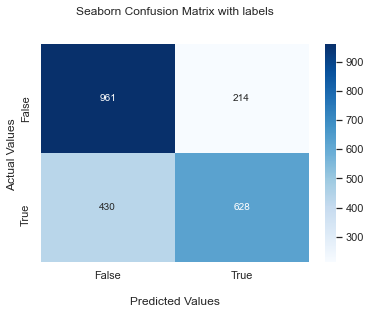

In [46]:
# confusion matrix
cf_matrix = metrics.confusion_matrix(y_test, pred)
print(cf_matrix)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')
# scientic notation: the param fmt='.2g' is being applied because you've set annot=True

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

_More on sns.heatmap() like showing number, percentage and labels like TP_, https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/

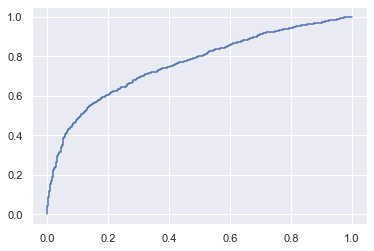

In [47]:
# calcualte Area Under Curve (AUC)

y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#plt.plot(dtc_eval['fpr'], dtc_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(dtc_eval['auc']))
plt.plot(fpr, tpr)

<font color=purple>With selected features if X_train becomes ndarray </font>
```
# sometimes after feature scaling, X_train becomes ndarray, so we have to select with index

features_selected = ['age', 'undergrad_gpa', 'conditional_admit', 'gender_Male',
       'gender_Other', 'track_Full Time', 'track_Part Time']
idx = X_train.columns.get_indexer(features_selected)
print(idx)

X_train = X_train_std_smote[:, idx]
y_train = y_train_smote

X_test = X_test[features_selected]

# then create a new dataFrame to train model
X_train_df = pd.DataFrame(X_train, columns=features_selected)
X_train_df = sm.add_constant(X_train_df)
reg_log = sm.Logit(y_train, X_train_df)
```